<a href="https://colab.research.google.com/github/Nawapon19/NLP/blob/main/SMS_Spam_Detection_using_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SMS Spam Detection using TensorFlow**

In [61]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

In [62]:
# load dataset to pandas dataframe
df = pd.read_csv('spam.csv', encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [63]:
# drop unrelevant columns unnamed : 2-4
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

# rename text column and label column
df = df.rename(columns = {'v1': 'label', 'v2': 'Text'})

# transform target variable from string to number using pandas.map()
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})

df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


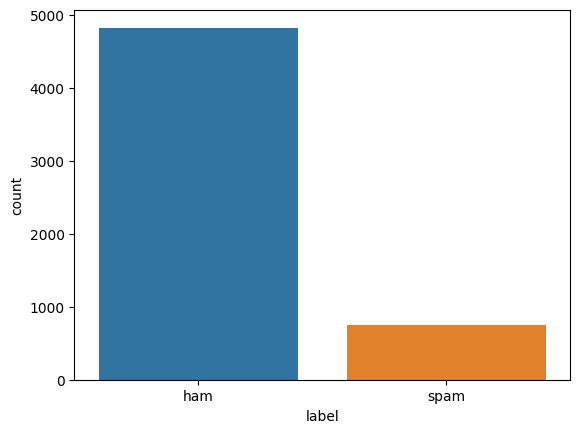

In [64]:
# visualize the distribution of Spam and non-Spam data
sns.countplot(x=df['label'])
plt.show()

The ham data is comparatively higher than spam data, it’s natural. Since we are going to use embeddings in our deep learning model, we need not balance the data.

In [65]:
# find average number of tokens in all sentences
avg_words_len = round(sum([len(i.split()) for i in df['Text']]) / len(df['Text']))
print(avg_words_len)

15


In [66]:
# find total number of unique words in the corpus
s = set()

for sentence in df['Text']:
  for word in sentence.split():
    s.add(word)

total_words_len = len(s)

print(total_words_len)

15585


In [67]:
# split data for training and testing
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})

X_train, X_test, y_train, y_test = train_test_split(new_df['Text'], new_df['label'],
                                                    test_size = 0.2, random_state = 42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

**Building the models**


* build MiltinomialNB as a baseline model
* MultinomialNB performs well for text classification when the features are discrete like word counts of the words or tf-idf vectors
* try to beat its performance using deep learning models



In [68]:
# transform training data and testing using tf-idf vectorizer
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec, X_test_vec = tfidf_vec.transform(X_train), tfidf_vec.transform(X_test)

# train the MultinomialNB model using training data
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec, y_train)

MultinomialNB()

In [69]:
X_train_vec, X_test_vec

(<4457x7735 sparse matrix of type '<class 'numpy.float64'>'
 	with 58978 stored elements in Compressed Sparse Row format>,
 <1115x7735 sparse matrix of type '<class 'numpy.float64'>'
 	with 13941 stored elements in Compressed Sparse Row format>)

In [70]:
# observe the performance of baseline model
nb_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))

print("Accuracy score of baseline model: ", nb_accuracy)
print("\nClassification report: \n", classification_report(y_test, baseline_model.predict(X_test_vec)))

Accuracy score of baseline model:  0.9623318385650225

Classification report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



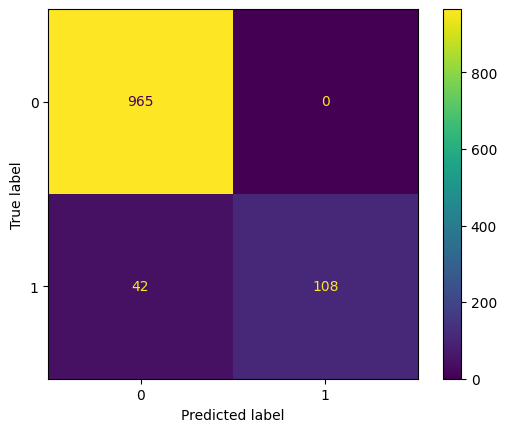

In [71]:
# observe the confusion matrix for baseline model
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test_vec, y_test)

**Model 1: Creating custom Text vectorization and embedding layers**

In [72]:
# create a custom text vectorization using tensorflow
max_tokens = total_words_len
output_len = avg_words_len

text_vec = TextVectorization(
    max_tokens = max_tokens,
    standardize = 'lower_and_strip_punctuation',
    output_mode = 'int',
    output_sequence_length = output_len
)

# apply to training data
text_vec.adapt(X_train)

In [73]:
# create an embedding layer
embedding_layer = layers.Embedding(
    input_dim = max_tokens, # size of vocabulary
    output_dim = 128, # dimension of the embedding layer
    embeddings_initializer = 'uniform',
    input_length = output_len
)

In [74]:
# build model 1
# create a sequnce of layers for model 1
input_layer = layers.Input(shape = (1, ), dtype = tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
# Flatten() reshapes the tensor by combining all dimensions except the batch size into one.
# On the other hand, GlobalAveragePooling1D() performs an average pooling operation, reducing the spatial dimensions.
x = layers.Dense(32, activation = 'relu')(x)
output_layer = layers.Dense(1, activation = 'sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer)

# compile the model with hyperparameters
model_1.compile(
    optimizer = 'adam',
    # compute the loss between the predicted labels and a smoothed version of the true labels,
    # where the smoothing squeezes the labels towards 0.5.
    loss = keras.losses.BinaryCrossentropy(label_smoothing = 0.5),
    metrics = ['accuracy']
)

In [75]:
# observe the summary of model 1
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d_4  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                4128

In [76]:
# train model 1
history_1 = model_1.fit(X_train, y_train,
                        epochs = 5,
                        validation_data = (X_test, y_test),
                        validation_steps = int(0.2 * len(X_test)))

Epoch 1/5
140/140 [==============================] - 6s 34ms/step - loss: 0.6051 - accuracy: 0.9089 - val_loss: 0.5768 - val_accuracy: 0.9740
Epoch 2/5
140/140 [==============================] - 4s 31ms/step - loss: 0.5700 - accuracy: 0.9881 - val_loss: 0.5733 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 4s 29ms/step - loss: 0.5658 - accuracy: 0.9960 - val_loss: 0.5728 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 4s 32ms/step - loss: 0.5642 - accuracy: 0.9984 - val_loss: 0.5725 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 4s 28ms/step - loss: 0.5634 - accuracy: 0.9989 - val_loss: 0.5728 - val_accuracy: 0.9803


<Axes: >

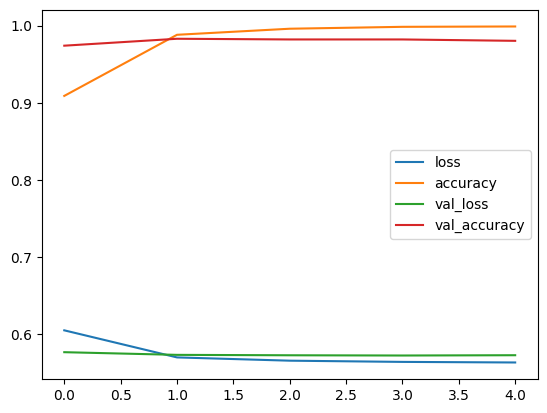

In [77]:
# plot the result of model 1
pd.DataFrame(history_1.history).plot()

In [78]:
# create helper functions for compiling, fitting and evaluating the model performance
# compiling function
def compile_model(model):
  # simply compile model with adam optimizer
  model.compile(optimizer = keras.optimizers.Adam(),
      loss = keras.losses.BinaryCrossentropy(),
      metrics = ['accuracy'])

# fitting function
def fit_model(model, epochs, X_train = X_train, y_train = y_train,
              X_test = X_test, y_test = y_test):
  history = model.fit(X_train, y_train,
                      epochs = epochs,
                      validation_data = (X_test, y_test),
                      validation_steps = int(0.2 * len(X_test)))
  return history

# evaluating model
def evaluate_model(model, X, y):
  # returns accuracy, precision, recall, and f-1 score
  y_preds = np.round(model.predict(X))
  accuracy = accuracy_score(y, y_preds)
  precision = precision_score(y, y_preds)
  recall = recall_score(y, y_preds)
  f1 = f1_score(y, y_preds)

  model_results_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1-score': f1}
  return model_results_dict

**Model -2 Bidirectional LSTM**

LSTM: Long short-term memory

BiLSTMs effectively improve the network’s accessible information, boosting the context for the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence)

In [79]:
# build model 2
# create a sequence of layers for model 2
input_layer = layers.Input(shape = (1, ), dtype = tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(64,
                                           activation = 'tanh',
                                           return_sequences = True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
# randomly sets input units to 0 with a frequency of rate(0.1) at each step during training time,
# which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - 0.1)
# such that the sum over all inputs is unchanged
x = layers.Dense(32, activation = 'relu')(dropout)
output_layer = layers.Dense(1, activation = 'sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer)

# compile the model
compile_model(model_2)

# fit the model
history_2 = fit_model(model_2, epochs = 5)

Epoch 1/5
140/140 [==============================] - 25s 106ms/step - loss: 0.0582 - accuracy: 0.9785 - val_loss: 0.0814 - val_accuracy: 0.9812
Epoch 2/5
140/140 [==============================] - 15s 105ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.1152 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 12s 85ms/step - loss: 4.8280e-05 - accuracy: 1.0000 - val_loss: 0.1250 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 13s 92ms/step - loss: 2.3318e-05 - accuracy: 1.0000 - val_loss: 0.1318 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 12s 88ms/step - loss: 1.4623e-05 - accuracy: 1.0000 - val_loss: 0.1370 - val_accuracy: 0.9821


**Model -3 Transfer Learning with USE Encoder**

USE Layer: Universal Sentence Encoder

The Universal Sentence Encoder converts text into high-dimensional vectors that may be used for text categorization, semantic similarity, and other natural language applications.

In [80]:
# build a sequential model
model_3 = keras.Sequential()

# universal-sentence-encoder layer from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable = False,
                           input_shape = [],
                           dtype = tf.string,
                           name = 'USE')

# add layers to the sequential model
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation = keras.activations.relu))
model_3.add(layers.Dense(1, activation = keras.activations.sigmoid))

# compile the model
compile_model(model_3)

# fit the model
fit_model(model_3, epochs = 5)

Epoch 1/5
140/140 [==============================] - 7s 25ms/step - loss: 0.2898 - accuracy: 0.9174 - val_loss: 0.1131 - val_accuracy: 0.9695
Epoch 2/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0806 - accuracy: 0.9794 - val_loss: 0.0703 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0570 - accuracy: 0.9825 - val_loss: 0.0592 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 4s 27ms/step - loss: 0.0444 - accuracy: 0.9870 - val_loss: 0.0552 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 3s 20ms/step - loss: 0.0396 - accuracy: 0.9883 - val_loss: 0.0507 - val_accuracy: 0.9830


**Analyze Model Performance**

In [81]:
# use the helper function to evaluate all models
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

# read all results to pandas dataframe
total_results = pd.DataFrame({'MultinomialNB Model': baseline_model_results,
                              'Custom-Vec-Embedding Model': model_1_results,
                              'Bidirectional-LSTM Model': model_2_results,
                              'USE-Transfer learning Model': model_3_results}).transpose()

total_results

35/35 [==============================] - 1s 18ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.981166,0.977778,0.880000,0.926316
Bidirectional-LSTM Model,0.982063,0.964286,0.900000,0.931034
USE-Transfer learning Model,0.982960,0.958042,0.913333,0.935154


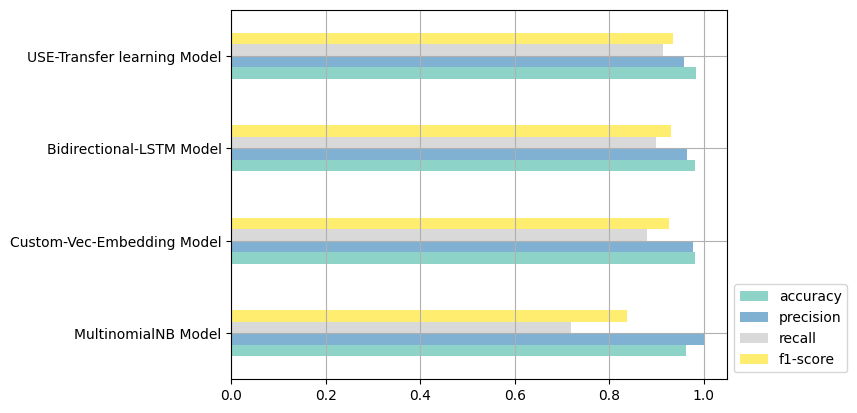

In [82]:
# plot all results
total_results.plot(kind='barh', grid = True, colormap='Set3').legend(loc='lower left',bbox_to_anchor=(1.0, 0.0))

Most of the data points contain the label “ham,” which is natural because most SMS are ham. Accuracy cannot be an appropriate metric in certain situations. Other measurements are required.

* False negative and false positive are significant in this problem. Precision and recall are the metrics that allow the ability to calculate them.
* The **f1-score** is the harmonic mean of accuracy and recall. Thus, get both with a single shot.
* **USE-Transfer learning model** gives the best accuracy and f1-score.